In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import plotnine
import seaborn as sns
import sklearn.metrics

%matplotlib inline

In [2]:
df = pd.read_csv('biorxiv_p_vs_rank.tsv.xz', sep='\t')

test_df = df.query('train != 1 and source != target')

test_df.head(2)

,mapped_source,mapped_target,source,target,train,test_recon,test_new,source_degree,target_degree,prior_empirical,rwr,mean_rwr,p_rwr,jaccard,mean_jaccard,p_jaccard
1,0,1,200080,200108,0.0,0.0,0.0,10.0,0.0,0.000,3.280382e-08,0.000063,1.0,0.0,0.009558,1.0
2,0,2,200080,200126,0.0,0.0,0.0,10.0,1.0,0.001,3.269325e-08,0.000076,1.0,0.0,0.009135,1.0


In [3]:
records = (
    (feature,
     sklearn.metrics.roc_auc_score(test_df['test_recon'], multiplier * test_df[feature]),
     sklearn.metrics.roc_auc_score(test_df['test_new'], multiplier * test_df[feature]))
    for feature, multiplier in {'prior_empirical': 1, 'rwr': 1, 'mean_rwr': 1, 'p_rwr': -1, 
                                'jaccard': 1, 'mean_jaccard': 1, 'p_jaccard': -1,
                               }.items()
)
info_df = pd.DataFrame.from_records(records, columns=['feature', 'reconstruction_auc', 'systematic_auc'])

info_df

,feature,reconstruction_auc,systematic_auc
0,prior_empirical,0.418387,0.489468
1,rwr,0.912873,0.882932
2,mean_rwr,0.368011,0.451399
3,p_rwr,0.880093,0.855156
4,jaccard,0.783464,0.796527
5,mean_jaccard,0.449229,0.508960
6,p_jaccard,0.783145,0.796486


In [4]:
colors = {
    'prior_empirical': 'prior',
    'mean_rwr': 'RWR', 'rwr': 'RWR', 'p_rwr': 'RWR',
    'mean_jaccard': 'Jaccard', 'jaccard': 'Jaccard', 'p_jaccard': 'Jaccard',
}
info_content = {
    'prior_empirical': 'no edge info',
    'mean_rwr': 'no edge info', 'rwr': 'feature', 'p_rwr': 'corrected feature',
    'mean_jaccard': 'no edge info', 'jaccard': 'feature', 'p_jaccard': 'corrected feature',
}

all_features_df = pd.DataFrame()
for feature, multiplier in {'prior_empirical': 1, 
                            'rwr': 1, 'mean_rwr': 1, 'p_rwr': -1, 
                            'jaccard': 1, 'mean_jaccard': 1, 'p_jaccard': -1,
                           }.items():
    train_df = pd.DataFrame()
    train_df['fpr'], train_df['tpr'], _ = sklearn.metrics.roc_curve(
        df.query('source != target')['train'], multiplier * df.query('source != target')[feature])
    train_df = train_df.assign(test='train')
    
    recon_df = pd.DataFrame()
    recon_df['fpr'], recon_df['tpr'], _ = sklearn.metrics.roc_curve(
        test_df['test_recon'], multiplier * test_df[feature])
    recon_df = recon_df.assign(test='reconstruction')
    
    systematic_df = pd.DataFrame()
    systematic_df['fpr'], systematic_df['tpr'], _ = sklearn.metrics.roc_curve(
        test_df['test_new'], multiplier * test_df[feature])
    systematic_df = systematic_df.assign(test='systematic')
    
    feature_df = pd.concat([train_df, recon_df, systematic_df], ignore_index=True).assign(
        feature=feature, color=colors[feature], info=info_content[feature])
    all_features_df = pd.concat([all_features_df, feature_df])

all_features_df.head()

,fpr,tpr,test,feature,color,info
0,0.000000e+00,0.000000,train,prior_empirical,prior,no edge info
1,1.882325e-07,0.000047,train,prior_empirical,prior,no edge info
2,3.764651e-07,0.000094,train,prior_empirical,prior,no edge info
3,7.529301e-07,0.000189,train,prior_empirical,prior,no edge info
4,1.129395e-06,0.000189,train,prior_empirical,prior,no edge info


/home/zietzm/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 12 x 6 in image.
  from_inches(height, units), units))
/home/zietzm/miniconda3/envs/xswap-analysis/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ../img/citation_roc.png
  warn('Filename: {}'.format(filename))


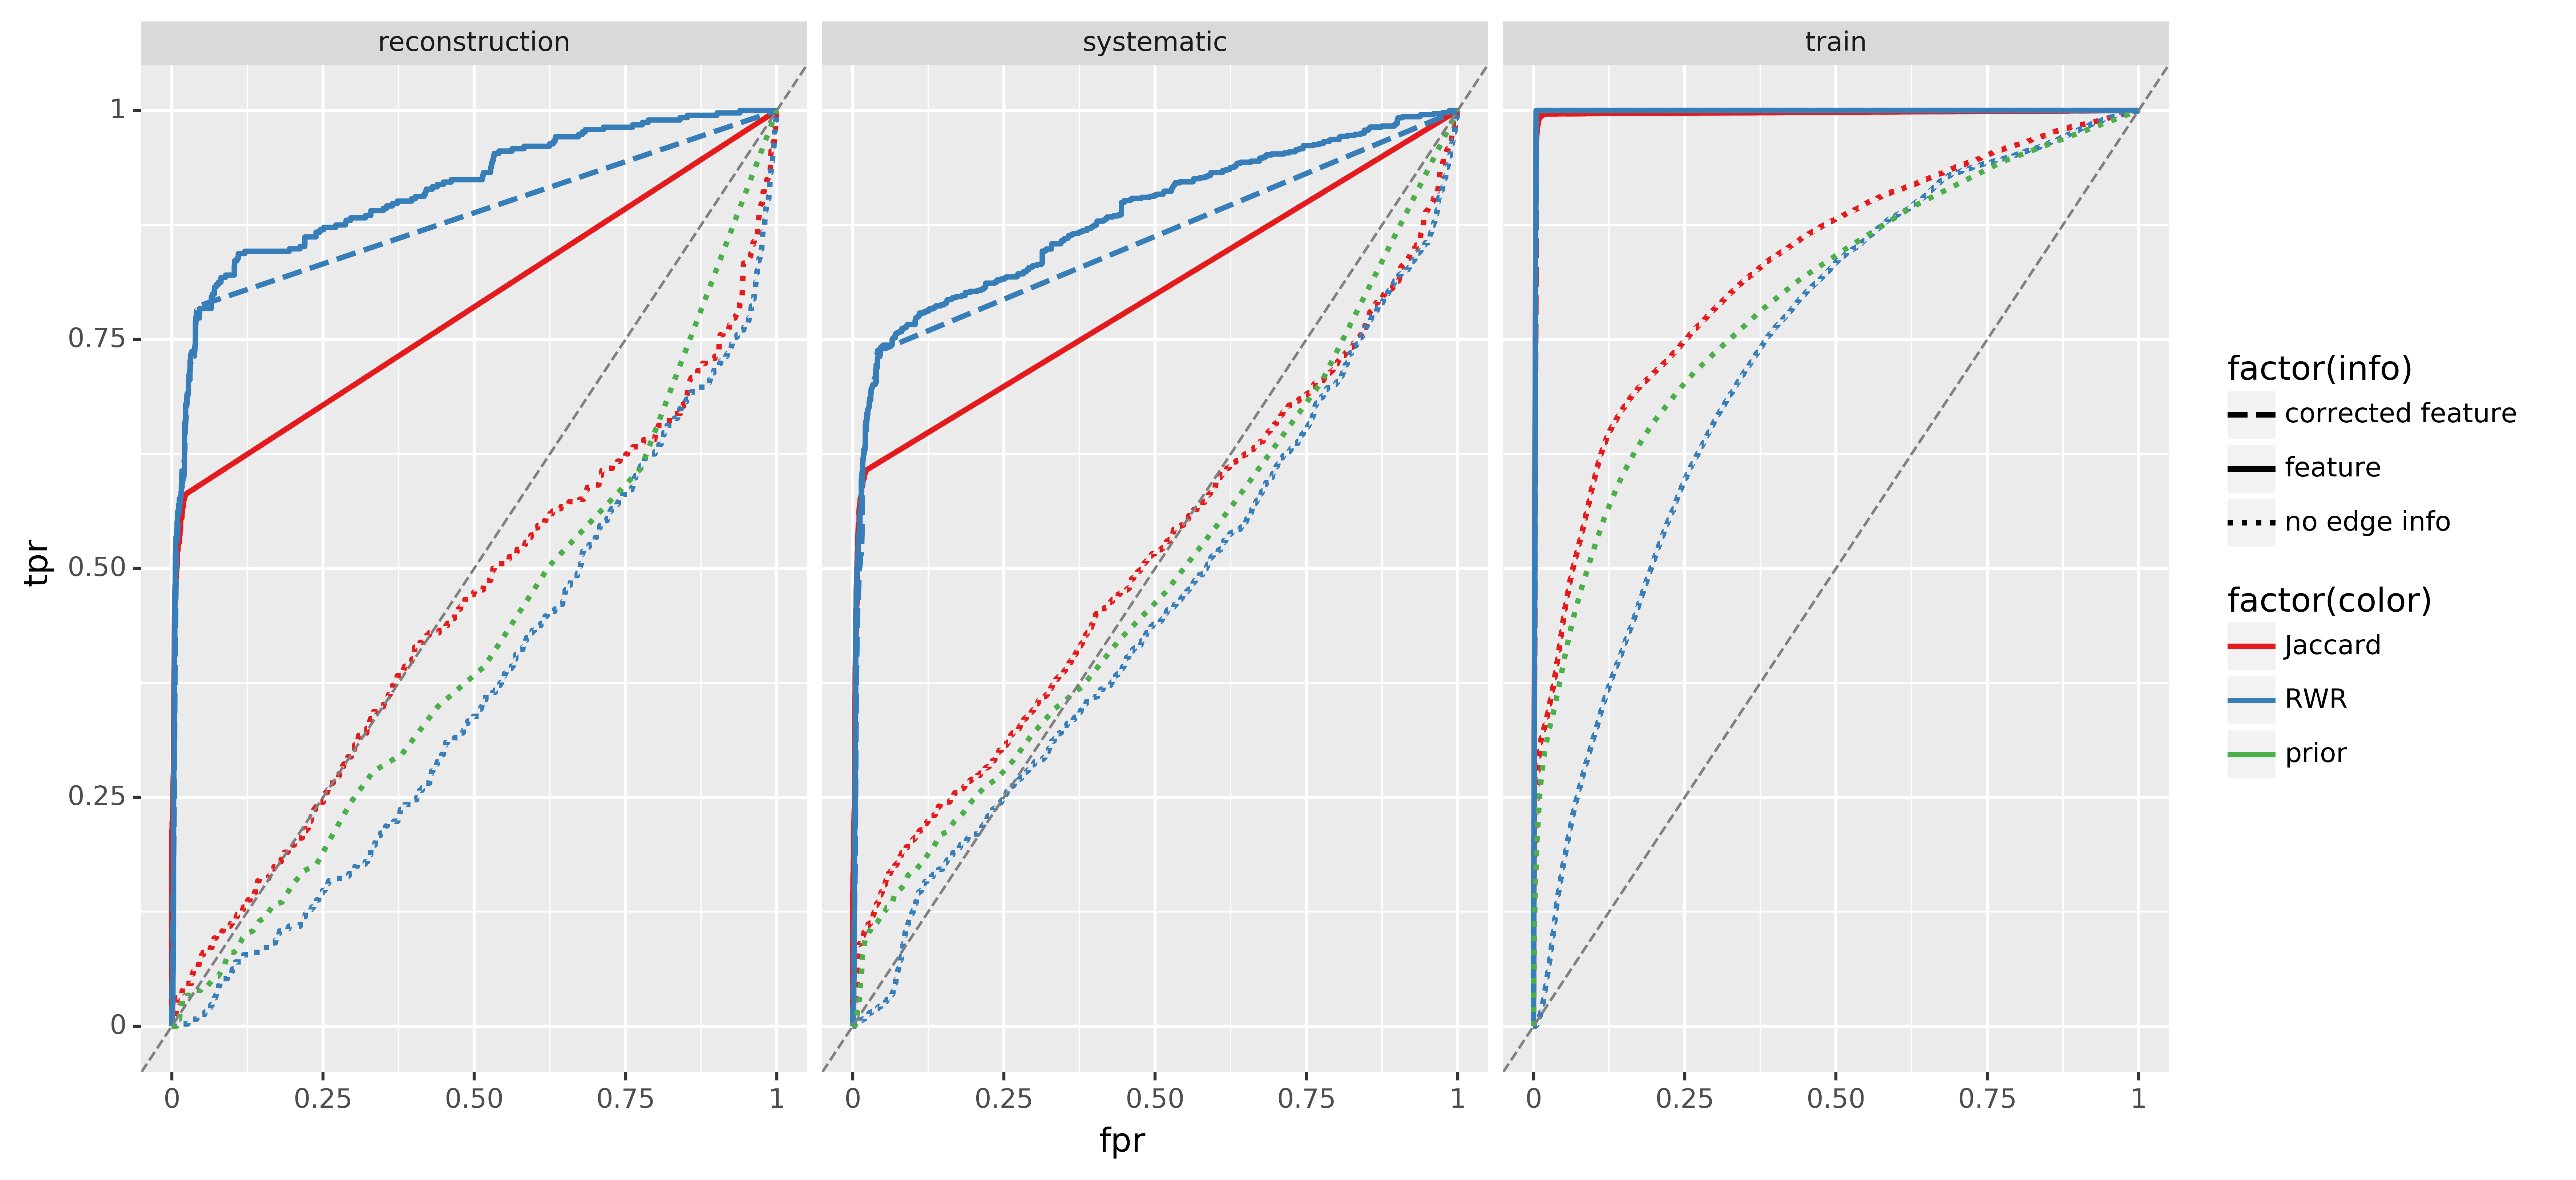

<ggplot: (8741576995115)>

In [5]:
plotnine.options.figure_size = (12, 6)
plotnine.options.dpi = 600
g = (
    plotnine.ggplot(all_features_df, plotnine.aes(x='fpr', y='tpr', color='factor(color)', 
                                                  linetype='factor(info)'))
    + plotnine.geom_line(size=1)
    + plotnine.facet_wrap('~test')
    + plotnine.geom_abline(slope=1, intercept=0, linetype='dashed', color='grey')
    + plotnine.scale_linetype_manual(values=['dashed', 'solid', 'dotted'])
    + plotnine.scale_color_brewer(type='qual', palette=6)
)
g.save('../img/citation_roc.png', dpi=500)
g

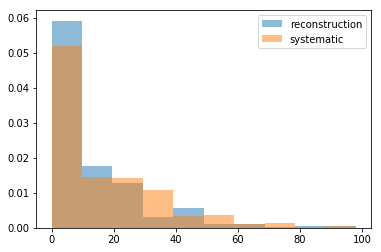

In [6]:
plt.hist(test_df.query('test_recon == 1 and train == 0')['source_degree'], label='reconstruction', alpha=0.5, density=True)
plt.hist(test_df.query('test_new == 1 and train == 0')['source_degree'], label='systematic', alpha=0.5, density=True)
plt.legend()

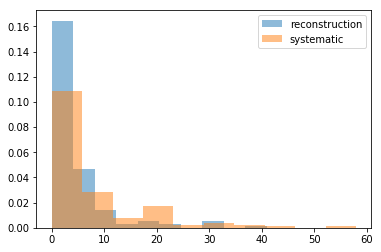

In [7]:
plt.hist(test_df.query('test_recon == 1 and train == 0')['target_degree'], label='reconstruction', alpha=0.5, density=True)
plt.hist(test_df.query('test_new == 1 and train == 0')['target_degree'], label='systematic', alpha=0.5, density=True)
plt.legend()